In [45]:
import pandas as pd
import numpy as np
from collections import Counter
import os

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [1]:
# Does this count?

## Some Label Notes

Source: http://rotoguru1.com/cgi-bin/mlb-dbd-2018.pl

- P/H: Designates 'Pitcher' or 'Hitter
- Hand: Designates 'Left', 'Right' or 'Both'
- H/A: Designates 'Home' or 'Away'
- Game#: Designates '1' or '2' if doubleheader
- Gametime_ET: Designates start of game EST
- ADI: Air Density Index (based on weather and elevation). Higher ADI means more ball movement is possible (Denver usually has lowest ADI), is displayed on a 100 scale and a comparative index (VMI) is used to determine the individual players' familiarity with how much movement he will face
- GS: 'Game Started', '1' designates starter, 'asp' reserved for some pitchers
- GP: 'Game Played', '1' for he played
- PA: Plate Appearances
- PA: unknown (ranges from 0.0 to 8.0)
- wOBA_num: "using Fangraphics base coefficients"
- QS: 'Quality Start', for pitchers

## FanDuel Scoring:
Hitters
- Singles: 3pts
- Doubles: 6pts
- Triples: 9pts
- Walks: 3pts
- HBP: 3pts
- Homeruns: 12pts
- Runs: 3.2pts
- RBI: 3.5pts
- Stolen Base: 6pts

Pitchers
- ER: -3pts
- IP: 3pts
- Qstart: 4pts
- SO: 3pts
- Wins: 6pts

In [64]:
def data_gen():
    # Read in all data into df
    # Replace 'batting.csv' with most recent update at rotoguru link
    df = pd.read_csv('../data/batting.csv', sep=':', index_col=False)
    
    # Drop information we're not interested in (i.e. stats other than FanDuel)
    drop_cols = ['DK_points', 'DD_points', 'YH_points', 'DK_salary', 'DD_salary', 'YH_salary',
                 'DK_pos', 'DD_pos', 'YH_pos']
    df = df.drop(drop_cols, axis=1)
    
    # Recast Date to datetime type, so we can apply rolling window stats later
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    
    # Sort and reset index for tidyness
    df = df.sort_values(['MLB_ID', 'Date'])
    df = df.reset_index(drop=True)
    
    return df

In [65]:
df = data_gen()

In [66]:
print(df.shape)

(9079, 38)


In [67]:
def split_hitters_pitchers(df):
    
    pitchers_df = df[df['P/H']=='P']
    
    hitters_df = df[df['P/H']=='H']
    
    # Drop pitching stats from hitters df
    hitters_df = hitters_df.drop(['IP', 'W/L/S', 'QS', 'prior_ADI', 'GS', 'GP'], axis=1)
    
    # Reset index for tidyness
    hitters_df.set_index(['MLB_ID', 'Date'], drop=False, inplace=True)
    
    return hitters_df, pitchers_df

In [68]:
hitters_df, pitchers_df = split_hitters_pitchers(df)

In [69]:
print(hitters_df.shape)
print(pitchers_df.shape)

(7639, 32)
(1440, 38)


In [70]:
pitchers_df.head()

,GID,MLB_ID,Name_Last_First,Name_First_Last,P/H,Hand,Date,Team,Oppt,H/A,...,Oppt_pitch_MLB_ID,Oppt_pitch_Name,PA,wOBA_num,IP,W/L/S,QS,FD_points,FD_salary,FD_pos
0,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-02,tex,oak,a,...,592811,"Triggs, Andrew",0.0,0.0,6.0,NaN,1.0,31.0,5600.0,1.0
1,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-15,tex,hou,a,...,434378,"Verlander, Justin",0.0,0.0,7.2,NaN,1.0,45.0,5500.0,1.0
2,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-21,tex,sea,h,...,572020,"Paxton, James",0.0,0.0,5.2,NaN,NaN,11.0,6800.0,1.0
3,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-28,tex,tor,a,...,448802,"Garcia, Jaime",0.0,0.0,7.0,W,1.0,28.0,6600.0,1.0
4,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-05-01,tex,cle,a,...,605182,"Clevinger, Mike",NaN,NaN,NaN,NaN,NaN,NaN,6600.0,1.0


In [71]:
def collapse_pitcher_stats(hitters_df, pitchers_df):
    
    # Set up empty dataframe
    pitchers_defense = pd.DataFrame(columns=['Game_ID', 'MLB_ID', 'Date', 'pts_per_PA'])
    
    # Subset just the hitting team against every pitcher for each game, and create a metric 
    # of how well that pitcher "holds-to-points" per plate appearance
    for i in pitchers_df.index:
        hit_team = pitchers_df.loc[i]['Oppt']

        df = hitters_df[(hitters_df['Game_ID']==pitchers_df.loc[i]['Game_ID']) & (hitters_df['Team']==hit_team)]
        try:
            pts_per_PA = df['FD_points'].sum() / df['PA'].sum()
        except:
            pts_per_PA = np.nan

        pitchers_defense = pitchers_defense.append({'Game_ID': pitchers_df.loc[i]['Game_ID'],
                                                    'MLB_ID': pitchers_df.loc[i]['MLB_ID'],
                                                    'Date': pitchers_df.loc[i]['Date'],
                                                    'pts_per_PA': pts_per_PA}, ignore_index=True)
    
    # Set MLB_ID from string type to int type
    pitchers_defense['MLB_ID'] = pitchers_defense['MLB_ID'].apply(lambda x: int(x))
    
    # Reset index for tidyness
    pitchers_defense.set_index(['MLB_ID', 'Date'], drop=False, inplace=True)
    
    return pitchers_defense

In [72]:
pitchers_defense = collapse_pitcher_stats(hitters_df, pitchers_df)

In [73]:
pitchers_defense.head(10)

Game_ID  MLB_ID       Date  pts_per_PA
MLB_ID Date                                                         
112526 2018-04-02  20180402-tex-oak-1  112526 2018-04-02    2.091176
       2018-04-15  20180415-tex-hou-1  112526 2018-04-15    0.930303
       2018-04-21  20180421-sea-tex-1  112526 2018-04-21    3.464103
       2018-04-28  20180428-tex-tor-1  112526 2018-04-28    2.552941
       2018-05-01  20180501-tex-cle-1  112526 2018-05-01         NaN
276542 2018-05-01  20180501-pit-was-1  276542 2018-05-01         NaN
279571 2018-05-01  20180501-tex-cle-1  279571 2018-05-01         NaN
282332 2018-03-31  20180331-nyy-tor-1  282332 2018-03-31    3.000000
       2018-04-06  20180406-bal-nyy-1  282332 2018-04-06    1.849091
       2018-04-19  20180419-tor-nyy-1  282332 2018-04-19    1.083784

In [74]:
pitchers_defense.shape

(1440, 4)

In [75]:
pitchers_defense.isnull().sum()

Game_ID         0
MLB_ID          0
Date            0
pts_per_PA    602
dtype: int64

In [76]:
pitchers_defense.dtypes

Game_ID               object
MLB_ID                 int64
Date          datetime64[ns]
pts_per_PA           float64
dtype: object

In [77]:
def append_rolling_pitchersdefense_to_hitters(pitchers_defense, hitters_df):
    pitcher_ids = pitchers_defense['MLB_ID'].unique()

    rolling_cols = ['pts_per_PA_ewm_10', 'pts_per_PA_rm_05', 'MLB_ID', 'Game_ID']
    
    pitchers_rolling = pd.DataFrame(columns = rolling_cols)
    window_stats = 'pts_per_PA'
    
    # Generate rollings stats
    for pitcher_id in pitcher_ids:
        pitcher_df = pitchers_defense.loc[pitcher_id]

        ewm_10 = pitcher_df[window_stats].ewm(span=10, min_periods=1).mean().shift()
        rm_05 = pitcher_df[window_stats].rolling(window=5, min_periods=1).mean().shift()

        this_df = pd.concat([ewm_10, rm_05], axis=1)

        this_df['MLB_ID'] = pitcher_id
        this_df['Game_ID'] = pitcher_df['Game_ID']
        this_df.columns = rolling_cols

        pitchers_rolling = pd.concat([pitchers_rolling, this_df])
     
    # Merge rolling pitcher_defense stats to hitters_df
    hitters_df = hitters_df.merge(pitchers_rolling, how='left', 
          left_on=['Oppt_pitch_MLB_ID', 'Game_ID'], 
          right_on=['MLB_ID', 'Game_ID'])

    # Drop/rename duplicated columns
    hitters_df.drop(['MLB_ID_y'], axis=1, inplace=True)
    hitters_df = hitters_df.rename(columns = {'MLB_ID_x':'MLB_ID'})
    
    # Reset index for tidiness
    hitters_df.set_index(['MLB_ID', 'Date', 'Game_ID'], drop=False, inplace=True)

    return(hitters_df)

In [78]:
hitters_df = append_rolling_pitchersdefense_to_hitters(pitchers_defense, hitters_df)

In [79]:
hitters_df.dtypes

GID                          object
MLB_ID                        int64
Name_Last_First              object
Name_First_Last              object
P/H                          object
Hand                         object
Date                 datetime64[ns]
Team                         object
Oppt                         object
H/A                          object
Game#                         int64
Game_ID                      object
Gametime_ET                 float64
Team_score                  float64
Oppt_score                  float64
Home_Ump                     object
Temp                        float64
Condition                    object
W_speed                     float64
W_dir                        object
ADI                         float64
Pos                          object
Order                       float64
Oppt_pitch_hand              object
Oppt_pich_GID                object
Oppt_pitch_MLB_ID            object
Oppt_pitch_Name              object
PA                          

In [80]:
def rolling_hitter_stats_gen(hitters_df):
    
    # We will separate hitting success against Left and Right handed pitchers
    hitters_L = hitters_df[hitters_df['Oppt_pitch_hand']=='L']
    hitters_R = hitters_df[hitters_df['Oppt_pitch_hand']=='R']
    
    hitter_ids = hitters_df['MLB_ID'].unique()
    window_stats = ['PA', 'Team_score', 'FD_points']
    
    rolling_cols = ['ewm05_PA', 'ewm05_Team_score', 'ewm05_FD_points',
                  'ewm25_PA', 'ewm25_Team_score', 'ewm25_FD_points',
                  'ewm50_PA', 'ewm50_Team_score', 'ewm50_FD_points',
                  'rm80_PA', 'rm80_Team_score', 'rm80_FD_points',
                  'MLB_ID', 'Game_ID']
    
    hitters_L_rolling = pd.DataFrame(columns=rolling_cols)
    hitters_R_rolling = pd.DataFrame(columns=rolling_cols)
    
    for hitter in hitter_ids:
        temp_L = hitters_L.loc[hitter]
        temp_R = hitters_R.loc[hitter]

        ewm_05L = temp_L[window_stats].ewm(span=5).mean().shift()
        ewm_25L = temp_L[window_stats].ewm(span=25).mean().shift()
        ewm_50L = temp_L[window_stats].ewm(span=50).mean().shift()
        rm_80L = temp_L[window_stats].rolling(window=80, min_periods=1).mean().shift()

        ewm_05R = temp_R[window_stats].ewm(span=5).mean().shift()
        ewm_25R = temp_R[window_stats].ewm(span=25).mean().shift()
        ewm_50R = temp_R[window_stats].ewm(span=50).mean().shift()
        rm_80R = temp_R[window_stats].rolling(window=80, min_periods=1).mean().shift()

        this_df_L = pd.concat([ewm_05L, ewm_25L, ewm_50L, rm_80L], axis=1)
        this_df_R = pd.concat([ewm_05R, ewm_25R, ewm_50R, rm_80R], axis=1)

        this_df_L['MLB_ID'] = hitter
        this_df_L['Game_ID'] = hitters_L.loc[hitter]['Game_ID']
        
        this_df_R['MLB_ID'] = hitter
        this_df_R['Game_ID'] = hitters_R.loc[hitter]['Game_ID']
        
        this_df_L.columns = rolling_cols
        this_df_R.columns = rolling_cols
        
        hitters_L_rolling = pd.concat([hitters_L_rolling, this_df_L])
        hitters_R_rolling = pd.concat([hitters_R_rolling, this_df_R])
    
    hitters_L_rolling['MLB_ID'] = hitters_L_rolling['MLB_ID'].apply(lambda x: int(x))
    hitters_R_rolling['MLB_ID'] = hitters_R_rolling['MLB_ID'].apply(lambda x: int(x))
     
    hitters_L_rolling.set_index(['MLB_ID', 'Game_ID'], drop=False, inplace=True)
    hitters_R_rolling.set_index(['MLB_ID', 'Game_ID'], drop=False, inplace=True)
    
    hitters_R_rolling = hitters_df.join(hitters_R_rolling, how='inner', on=['MLB_ID', 'Game_ID'], rsuffix='_r')
    hitters_L_rolling = hitters_df.join(hitters_L_rolling, how='inner', on=['MLB_ID', 'Game_ID'], rsuffix='_r')
    
    print(hitters_R_rolling.shape)
    print(hitters_L_rolling.shape)
    hitters_modeling = pd.concat([hitters_R_rolling, hitters_L_rolling], join='inner')
    
    # Drop duplicated columns
    hitters_modeling.drop(['MLB_ID_r', 'Game_ID_r'], axis=1, inplace=True)
    
    return hitters_modeling

In [81]:
hitters_modeling = rolling_hitter_stats_gen(hitters_df)

(5328, 48)
(2311, 48)


In [82]:
hitters_modeling.shape

(7639, 46)

In [83]:
hitters_modeling.dtypes

GID                          object
MLB_ID                        int64
Name_Last_First              object
Name_First_Last              object
P/H                          object
Hand                         object
Date                 datetime64[ns]
Team                         object
Oppt                         object
H/A                          object
Game#                         int64
Game_ID                      object
Gametime_ET                 float64
Team_score                  float64
Oppt_score                  float64
Home_Ump                     object
Temp                        float64
Condition                    object
W_speed                     float64
W_dir                        object
ADI                         float64
Pos                          object
Order                       float64
Oppt_pitch_hand              object
Oppt_pich_GID                object
Oppt_pitch_MLB_ID            object
Oppt_pitch_Name              object
PA                          

In [84]:
hitters_modeling.isnull().sum()

GID                     0
MLB_ID                  0
Name_Last_First         0
Name_First_Last         0
P/H                     0
Hand                    0
Date                    0
Team                    0
Oppt                    0
H/A                     0
Game#                   0
Game_ID                 0
Gametime_ET             0
Team_score            511
Oppt_score            511
Home_Ump              135
Temp                  511
Condition             511
W_speed               511
W_dir                 511
ADI                    52
Pos                   511
Order                 511
Oppt_pitch_hand         0
Oppt_pich_GID           0
Oppt_pitch_MLB_ID       0
Oppt_pitch_Name         0
PA                    511
wOBA_num              511
FD_points             511
FD_salary             212
FD_pos                212
pts_per_PA_ewm_10    1600
pts_per_PA_rm_05     1600
ewm05_PA              908
ewm05_Team_score      908
ewm05_FD_points       908
ewm25_PA              908
ewm25_Team_s

In [85]:
test = hitters_modeling.dropna()

In [86]:
test.shape

(5158, 46)

In [87]:
def dummify_and_clean(hitters_modeling):
    
    #print(hitters_modeling.shape)
    #hitters_modeling = hitters_modeling.dropna()
    #print(hitters_modeling.shape)
    
    drop_cols = ['GID', 'MLB_ID', 'Name_Last_First', 'P/H', 'Team', 'Oppt',
                 'Game_ID', 'Team_score', 'Oppt_score', 'Home_Ump', 'Oppt_pitch_hand',
                 'Oppt_pich_GID', 'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA']
    
    hitters_modeling = hitters_modeling.drop(drop_cols, axis=1)
    
    hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Hand'], drop_first=True)], axis=1).drop('Hand', axis=1)
    hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['H/A'], drop_first=True)], axis=1).drop('H/A', axis=1)
    hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Game#'], drop_first=True)], axis=1).drop('Game#', axis=1)
    hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Condition'], drop_first=True)], axis=1).drop('Condition', axis=1)
    hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['W_dir'], drop_first=True)], axis=1).drop('W_dir', axis=1)
    
    hitters_modeling['Night_game'] = hitters_modeling['Gametime_ET'].apply([lambda x: 0 if x < 16 else 1])
    hitters_modeling = hitters_modeling.drop('Gametime_ET', axis=1)
    
    return hitters_modeling

In [88]:
hitters_clean = dummify_and_clean(hitters_modeling)

In [89]:
hitters_clean.head()

Name_First_Last       Date  Temp  \
MLB_ID Date       Game_ID                                               
134181 2018-03-29 20180329-hou-tex-1   Adrian Beltre 2018-03-29  63.0   
       2018-03-31 20180331-hou-tex-1   Adrian Beltre 2018-03-31  73.0   
       2018-04-01 20180401-hou-tex-1   Adrian Beltre 2018-04-01  71.0   
       2018-04-02 20180402-tex-oak-1   Adrian Beltre 2018-04-02  59.0   
       2018-04-03 20180403-tex-oak-1   Adrian Beltre 2018-04-03  58.0   

                                      W_speed    ADI Pos  Order  wOBA_num  \
MLB_ID Date       Game_ID                                                   
134181 2018-03-29 20180329-hou-tex-1      2.0  64.75  3B    4.0      1.80   
       2018-03-31 20180331-hou-tex-1     19.0  62.12  3B    3.0      1.25   
       2018-04-01 20180401-hou-tex-1      9.0  62.35  DH    3.0      0.70   
       2018-04-02 20180402-tex-oak-1     11.0  71.17  3B    4.0      0.00   
       2018-04-03 20180403-tex-oak-1      7.0  71.58  3B    4.0      0.90   

                                      FD_points  FD_salary     ...      \
MLB_ID Date       Game_ID                                      ...       
134181 2018-03-29 20180329-hou-tex-1        6.0     3000.0     ...       
       2018-03-31 20180331-hou-tex-1        9.5     3100.0     ...       
       2018-04-01 20180401-hou-tex-1        3.0     3100.0     ...       
       2018-04-02 20180402-tex-oak-1        0.0     3200.0     ...       
       2018-04-03 20180403-tex-oak-1        6.2     2900.0     ...       

                                      In from LF  In from RF  L to R  None  \
MLB_ID Date       Game_ID                                                    
134181 2018-03-29 20180329-hou-tex-1           0           0       0     0   
       2018-03-31 20180331-hou-tex-1           0           0       0     0   
       2018-04-01 20180401-hou-tex-1           0           1       0     0   
       2018-04-02 20180402-tex-oak-1           0           0       0     0   
       2018-04-03 20180403-tex-oak-1           0           0       0     0   

                                      Out to CF  Out to LF  Out to RF  R to L  \
MLB_ID Date       Game_ID                                                       
134181 2018-03-29 20180329-hou-tex-1          1          0          0       0   
       2018-03-31 20180331-hou-tex-1          0          0          0       0   
       2018-04-01 20180401-hou-tex-1          0          0          0       0   
       2018-04-02 20180402-tex-oak-1          0          0          1       0   
       2018-04-03 20180403-tex-oak-1          0          0          1       0   

                                      Varies  Night_game  
MLB_ID Date       Game_ID                                 
134181 2018-03-29 20180329-hou-tex-1       0           0  
       2018-03-31 20180331-hou-tex-1       0           1  
       2018-04-01 20180401-hou-tex-1       0           0  
       2018-04-02 20180402-tex-oak-1       0           1  
       2018-04-03 20180403-tex-oak-1       0           1  

[5 rows x 49 columns]

In [90]:
hitters_clean.dtypes

Name_First_Last              object
Date                 datetime64[ns]
Temp                        float64
W_speed                     float64
ADI                         float64
Pos                          object
Order                       float64
wOBA_num                    float64
FD_points                   float64
FD_salary                   float64
FD_pos                      float64
pts_per_PA_ewm_10           float64
pts_per_PA_rm_05            float64
ewm05_PA                    float64
ewm05_Team_score            float64
ewm05_FD_points             float64
ewm25_PA                    float64
ewm25_Team_score            float64
ewm25_FD_points             float64
ewm50_PA                    float64
ewm50_Team_score            float64
ewm50_FD_points             float64
rm80_PA                     float64
rm80_Team_score             float64
rm80_FD_points              float64
L                             uint8
R                             uint8
h                           

## Modeling - Hitters

In [94]:
hitters_clean_past = hitters_clean[hitters_clean['Date'] != '2018-05-01']
for_modeling = hitters_clean_past.dropna()

In [99]:
hitters_clean[hitters_clean['Date'] == '2018-05-01'].shape

(511, 49)

In [98]:
hitters_clean[hitters_clean['Date'] == '2018-05-01'].isnull().sum()

Name_First_Last        0
Date                   0
Temp                 511
W_speed              511
ADI                    0
Pos                  511
Order                511
wOBA_num             511
FD_points            511
FD_salary             48
FD_pos                48
pts_per_PA_ewm_10     17
pts_per_PA_rm_05      17
ewm05_PA             101
ewm05_Team_score     101
ewm05_FD_points      101
ewm25_PA             101
ewm25_Team_score     101
ewm25_FD_points      101
ewm50_PA             101
ewm50_Team_score     101
ewm50_FD_points      101
rm80_PA              101
rm80_Team_score      101
rm80_FD_points       101
L                      0
R                      0
h                      0
2                      0
cloudy                 0
dome                   0
drizzle                0
overcast               0
partly cloudy          0
rain                   0
roof closed            0
snow                   0
sunny                  0
In from CF             0
In from LF             0


In [103]:
X = for_modeling.drop(['Name_First_Last', 'Date', 'Pos', 'FD_pos', # Cannot be modeled
                       'FD_points'], axis=1)

y = for_modeling['FD_points']

In [104]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3610, 44)
(3610,)
(1548, 44)
(1548,)


In [106]:
linreg = LinearRegression()

In [107]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [108]:
cross_val_score(linreg, X_train, y_train, cv=5)

array([0.82240932, 0.82784051, 0.82409269, 0.82102067, 0.81943844])

In [109]:
cross_val_score(linreg, X_test, y_test, cv=3)

array([0.83271759, 0.83823799, 0.82955828])

In [110]:
preds = linreg.predict(X_test)

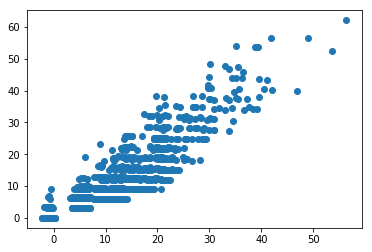

In [111]:
plt.scatter(preds, y_test)

In [112]:
rfr = RandomForestRegressor()

In [113]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
cross_val_score(rfr, X_test, y_test)

array([0.84640674, 0.82537525, 0.83893236])

In [115]:
rfr.feature_importances_

array([5.73910914e-03, 5.33470551e-03, 9.59405187e-03, 5.31949524e-03,
       8.76979914e-01, 7.60029578e-03, 7.60577381e-03, 7.23503267e-03,
       5.78630080e-03, 7.66892836e-03, 7.87900344e-03, 3.26292650e-03,
       4.28588024e-03, 4.61752768e-03, 2.76835765e-03, 5.75373782e-03,
       3.59178636e-03, 3.47849273e-03, 4.14286044e-03, 4.59328031e-03,
       9.38920398e-04, 9.47043261e-04, 1.62836677e-03, 6.71991142e-04,
       1.09233843e-03, 4.32209652e-04, 3.65641395e-04, 7.25743273e-04,
       9.48524062e-04, 2.20093757e-04, 2.96489135e-04, 0.00000000e+00,
       9.24275313e-04, 6.85375631e-04, 8.40114433e-04, 6.75405633e-04,
       6.15547717e-04, 2.51625621e-04, 6.23792101e-04, 6.38131282e-04,
       1.20269951e-03, 7.23709496e-04, 3.44329769e-04, 9.70171737e-04])

# Try to find value out of $ and Predictions

In [120]:
today_df = hitters_clean[hitters_clean['Date'] == '2018-05-01']

In [123]:
today_df.sort_values('FD_salary')[today_df.columns[7:]]

,,,wOBA_num,FD_points,FD_salary,FD_pos,pts_per_PA_ewm_10,pts_per_PA_rm_05,ewm05_PA,ewm05_Team_score,ewm05_FD_points,ewm25_PA,...,In from LF,In from RF,L to R,None,Out to CF,Out to LF,Out to RF,R to L,Varies,Night_game
MLB_ID,Date,Game_ID,,,,,,,,,,,,,,,,,,,,,
134181,2018-05-01,20180501-tex-cle-1,NaN,NaN,2000.0,5.0,1.635875,1.574538,4.077401,3.543080,12.388574,4.191394,...,0,0,0,0,0,0,0,0,0,1
643265,2018-05-01,20180501-phi-mia-1,NaN,NaN,2000.0,7.0,NaN,NaN,2.000000,2.000000,3.000000,2.000000,...,0,0,0,0,0,0,0,0,0,1
642180,2018-05-01,20180501-nyy-hou-1,NaN,NaN,2000.0,4.0,1.279899,1.435056,3.468517,3.858208,3.581427,3.598100,...,0,0,0,0,0,0,0,0,0,1
543484,2018-05-01,20180501-tam-det-1,NaN,NaN,2000.0,7.0,2.793882,2.890284,3.486598,1.903093,2.080127,3.875058,...,0,0,0,0,0,0,0,0,0,1
642162,2018-05-01,20180501-col-chc-1,NaN,NaN,2000.0,6.0,2.038813,2.084744,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
641933,2018-05-01,20180501-chw-stl-1,NaN,NaN,2000.0,7.0,2.413557,2.385764,4.000000,9.000000,3.500000,4.000000,...,0,0,0,0,0,0,0,0,0,1
543776,2018-05-01,20180501-phi-mia-1,NaN,NaN,2000.0,7.0,NaN,NaN,3.847895,2.738407,1.270753,3.872342,...,0,0,0,0,0,0,0,0,0,1
641924,2018-05-01,20180501-mil-cin-1,NaN,NaN,2000.0,2.0,2.754138,2.832819,3.000000,2.000000,0.000000,3.000000,...,0,0,0,0,0,0,0,0,0,1
543281,2018-05-01,20180501-pit-was-1,NaN,NaN,2000.0,4.0,1.433851,1.472013,3.599872,5.530112,5.331022,4.339857,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# test_hitters: 642162, 545337,643603

In [126]:
hitters_clean.loc[642162][hitters_clean.columns[14:]]

,,ewm05_Team_score,ewm05_FD_points,ewm25_PA,ewm25_Team_score,ewm25_FD_points,ewm50_PA,ewm50_Team_score,ewm50_FD_points,rm80_PA,rm80_Team_score,...,In from LF,In from RF,L to R,None,Out to CF,Out to LF,Out to RF,R to L,Varies,Night_game
Date,Game_ID,,,,,,,,,,,,,,,,,,,,,
2018-05-01,20180501-col-chc-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2018-04-04,20180404-col-sdg-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,1
2018-04-05,20180405-col-sdg-1,5.000000,0.000000,4.000000,5.000000,0.000000,4.000000,5.000000,0.000000,4.000000,5.000000,...,0,0,1,0,0,0,0,0,0,0
2018-04-08,20180408-atl-col-1,3.800000,1.800000,3.480000,3.960000,1.560000,3.490000,3.980000,1.530000,3.500000,4.000000,...,0,0,1,0,0,0,0,0,0,0
2018-04-09,20180409-sdg-col-1,2.000000,3.789474,3.307036,2.533049,3.159915,3.320091,2.599920,3.079989,3.333333,2.666667,...,0,0,0,0,0,0,0,1,0,1
2018-04-10,20180410-sdg-col-1,3.661538,2.215385,3.501597,3.506454,2.272716,3.500400,3.501607,2.263189,3.500000,3.500000,...,0,0,0,0,0,0,0,0,0,1
2018-04-12,20180412-col-was-1,3.023697,1.364929,3.384612,3.155111,1.742661,3.392157,3.176790,1.773631,3.400000,3.200000,...,0,0,0,0,1,0,0,0,0,1
2018-04-16,20180416-col-pit-1,3.745865,0.866165,3.508735,3.527223,1.391168,3.503859,3.511838,1.447693,3.500000,3.500000,...,0,0,0,0,1,0,0,0,0,1
2018-04-28,20180428-col-mia-1,4.543953,1.621661,3.596831,3.970651,1.679670,3.583519,3.911335,1.696930,3.571429,3.857143,...,0,1,0,0,0,0,0,0,0,1


In [107]:
X.reset_index(inplace=True)

In [124]:
today_df

,GID,MLB_ID,Name_Last_First,Name_First_Last,P/H,Hand,Date,Team,Oppt,H/A,...,DD_points,YH_points,FD_salary,DK_salary,DD_salary,YH_salary,FD_pos,DK_pos,DD_pos,YH_pos
30,142v,613534,"Adams, Austin",Austin Adams,P,R,20180430,was,pit,h,...,NaN,NaN,5500.0,4000.0,NaN,NaN,1.0,1.0,NaN,NaN
32,3223,571431,"Adams, Matt",Matt Adams,H,L,20180430,was,pit,h,...,NaN,NaN,2000.0,3400.0,NaN,12.0,3.0,37.0,NaN,3.0
43,6297,501303,"Adrianza, Ehire",Ehire Adrianza,H,B,20180430,min,tor,h,...,NaN,NaN,2300.0,2500.0,NaN,7.0,6.0,6.0,NaN,6.0
53,2415,542583,"Aguilar, Jesus",Jesus Aguilar,H,R,20180430,mil,cin,a,...,NaN,NaN,2800.0,3100.0,NaN,14.0,3.0,3.0,NaN,3.0
63,2500,605113,"Ahmed, Nick",Nick Ahmed,H,R,20180430,ari,lad,h,...,NaN,NaN,3200.0,3100.0,NaN,13.0,6.0,6.0,NaN,6.0
86,1602,458006,"Albers, Matt",Matt Albers,P,R,20180430,mil,cin,a,...,NaN,NaN,5500.0,4000.0,NaN,25.0,1.0,1.0,NaN,1.0
114,144t,645261,"Alcantara, Sandy",Sandy Alcantara,P,R,20180430,mia,phi,h,...,NaN,NaN,NaN,4000.0,NaN,NaN,NaN,1.0,NaN,NaN
115,131q,518397,"Alexander, Scott",Scott Alexander,P,L,20180430,lad,ari,a,...,NaN,NaN,5500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
116,2667,595751,"Alfaro, Jorge",Jorge Alfaro,H,R,20180430,phi,mia,a,...,NaN,NaN,2000.0,2800.0,NaN,9.0,2.0,2.0,NaN,2.0
132,2778,546990,"Alford, Anthony",Anthony Alford,H,R,20180430,tor,min,a,...,NaN,NaN,2000.0,2500.0,NaN,NaN,7.0,7.0,NaN,NaN


In [116]:
pd.to_datetime(todays_date)

Timestamp('2018-04-29 00:00:00')

In [122]:
df['preds'] = rfr.predict(X['Date']==todays_date)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [494]:
X

Temp  W_speed    ADI  Order  wOBA_num  \
MLB_ID Date       Game_ID                                                     
134181 2018-04-03 20180403-tex-oak-1  58.0      7.0  71.58    4.0      0.90   
       2018-04-05 20180405-tex-oak-1  60.0      4.0  70.77    4.0      2.85   
       2018-04-06 20180406-tor-tex-1  74.0     11.0  60.67    4.0      3.05   
       2018-04-09 20180409-laa-tex-1  69.0     11.0  66.95    4.0      1.60   
       2018-04-13 20180413-tex-hou-1  73.0      0.0  62.43    4.0      0.00   
       2018-04-14 20180414-tex-hou-1  64.0      0.0  68.77    4.0      3.60   
       2018-04-15 20180415-tex-hou-1  67.0     13.0  70.02    4.0      0.70   
       2018-04-17 20180417-tex-tam-1  72.0      0.0  66.98    4.0      0.90   
       2018-04-18 20180418-tex-tam-1  72.0      0.0  67.16    4.0      2.50   
       2018-04-20 20180420-sea-tex-1  69.0     14.0  67.33    4.0      0.70   
       2018-04-23 20180423-oak-tex-1  75.0     10.0  64.68    4.0      1.25   
       2018-04-24 20180424-oak-tex-1  82.0      5.0  62.99    4.0      1.80   
400085 2018-04-04 20180404-sea-sfo-1  62.0     16.0  70.38    8.0      0.00   
       2018-04-05 20180405-sea-min-1  38.0      7.0  73.77    8.0      0.90   
       2018-04-07 20180407-sea-min-1  27.0     12.0  78.24    8.0      1.80   
       2018-04-09 20180409-sea-kan-1  42.0      9.0  72.41    8.0      0.00   
       2018-04-13 20180413-oak-sea-1  55.0      0.0  73.63    8.0      0.00   
       2018-04-14 20180414-oak-sea-1  51.0      1.0  73.02    8.0      0.90   
       2018-04-17 20180417-hou-sea-1  51.0      0.0  74.67    8.0      0.90   
       2018-04-28 20180428-sea-cle-1  41.0     12.0  72.95    8.0      0.00   
400121 2018-04-05 20180405-det-chw-1  43.0     10.0  75.63    5.0      3.75   
       2018-04-07 20180407-det-chw-1  32.0      9.0  76.53    5.0      1.40   
       2018-04-09 20180409-det-cle-1  33.0     10.0  75.47    5.0      0.90   
       2018-04-10 20180410-det-cle-1  40.0      9.0  75.04    5.0      0.70   
       2018-04-11 20180411-det-cle-1  54.0     10.0  70.10    5.0      0.70   
       2018-04-17 20180417-bal-det-1  37.0     15.0  73.38    5.0      3.80   
       2018-04-18 20180418-bal-det-1  36.0      5.0  71.87    5.0      0.90   
       2018-04-19 20180419-bal-det-1  45.0     12.0  73.91    5.0      2.15   
       2018-04-20 20180420-kan-det-1  49.0      5.0  73.18    5.0      0.00   
                  20180420-kan-det-2  55.0      8.0  73.18    4.0      0.70   
...                                    ...      ...    ...    ...       ...   
660271 2018-04-04 20180404-cle-laa-1  65.0      6.0  65.92    8.0      2.90   
       2018-04-06 20180406-oak-laa-1  65.0      4.0  67.78    8.0      2.70   
       2018-04-12 20180412-laa-kan-1  79.0     15.0  59.88    8.0      2.30   
       2018-04-13 20180413-laa-kan-1  69.0      8.0  60.53    7.0      2.15   
       2018-04-22 20180422-sfo-laa-1  78.0     10.0  63.73    4.0      0.90   
       2018-04-27 20180427-nyy-laa-1  65.0      8.0  68.39    5.0      2.00   
660670 2018-04-27 20180427-atl-phi-1  58.0      4.0  70.07    6.0      2.15   
       2018-04-28 20180428-atl-phi-1  74.0     14.0  67.71    5.0      0.70   
       2018-04-29 20180429-atl-phi-1  55.0     15.0  71.89    2.0      3.90   
664023 2018-04-07 20180407-chc-mil-1  64.0      0.0  64.61    1.0      0.90   
       2018-04-10 20180410-pit-chc-1  43.0      5.0  73.86    1.0      0.70   
       2018-04-13 20180413-atl-chc-1  42.0     17.0  63.47    1.0      2.15   
       2018-04-17 20180417-stl-chc-1  35.0     10.0  74.19    1.0      0.70   
       2018-04-24 20180424-chc-cle-1  56.0     13.0  70.36    9.0      3.80   
       2018-04-25 20180425-chc-cle-1  45.0      9.0  72.90    9.0      0.70   
664056 2018-04-15 20180415-stl-cin-1  53.0      2.0  68.00    7.0      2.70   
       2018-04-21 20180421-cin-stl-1  66.0     10.0  69.92    8.0      1.60   
       2018-04-22 20180422-cin-stl-1  58.0     12.0  68.69    8.0      1.80   
664057 20

In [487]:
df_R['predpts/dollar'] = df_R['preds'] / df_R['FD_salary']

In [490]:
df_R[df_R['Date'] == '20180430'].sort_values('predpts/dollar', ascending=False)

,,,Name_First_Last,Date,Temp,W_speed,ADI,Pos,Order,wOBA_num,FD_points,FD_salary,...,L to R,None,Out to CF,Out to LF,Out to RF,R to L,Varies,Night_game,preds,predpts/dollar
MLB_ID,Date,Game_ID,,,,,,,,,,,,,,,,,,,,,


In [489]:
df_R['preds'].describe()

count    3502.000000
mean        9.498592
std         9.174827
min         0.000000
25%         3.320000
50%         6.950000
75%        13.620000
max        50.390000
Name: preds, dtype: float64

# ----- GRAVEYARD ----

In [329]:
# In YYYYMMDD format
todays_date = 20180430

---

In [330]:
# Separate today (unknown result) from balance
today_df = df[df['Date']== todays_date]
df = df[df['Date'] != todays_date]

In [331]:
todays_date = pd.to_datetime(todays_date, format='%Y%m%d')

In [332]:
today_df.shape

(810, 47)

In [333]:
df.drop(['DK_points', 'DD_points', 'YH_points', 'DK_salary', 'DD_salary', 'YH_salary',
             'DK_pos', 'DD_pos', 'YH_pos'], axis=1, inplace=True)

today_df.drop(['DK_points', 'DD_points', 'YH_points', 'DK_salary', 'DD_salary', 'YH_salary',
             'DK_pos', 'DD_pos', 'YH_pos'], axis=1, inplace=True)

In [334]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
today_df['Date'] = pd.to_datetime(today_df['Date'], format='%Y%m%d')

In [336]:
df.sort_values(['MLB_ID', 'Date'], inplace=True)
today_df.sort_values(['MLB_ID', 'Date'], inplace=True)

In [337]:
df.reset_index(drop=True, inplace=True)
today_df.reset_index(drop=True, inplace=True)

In [338]:
df.head()

,GID,MLB_ID,Name_Last_First,Name_First_Last,P/H,Hand,Date,Team,Oppt,H/A,...,Oppt_pitch_MLB_ID,Oppt_pitch_Name,PA,wOBA_num,IP,W/L/S,QS,FD_points,FD_salary,FD_pos
0,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-02,tex,oak,a,...,592811,"Triggs, Andrew",0.0,0.0,6.0,NaN,1.0,31.0,5600.0,1.0
1,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-15,tex,hou,a,...,434378,"Verlander, Justin",0.0,0.0,7.2,NaN,1.0,45.0,5500.0,1.0
2,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-21,tex,sea,h,...,572020,"Paxton, James",0.0,0.0,5.2,NaN,NaN,11.0,6800.0,1.0
3,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-28,tex,tor,a,...,448802,"Garcia, Jaime",0.0,0.0,7.0,W,1.0,28.0,6600.0,1.0
4,5006,134181,"Beltre, Adrian",Adrian Beltre,H,R,2018-03-29,tex,hou,h,...,434378,"Verlander, Justin",4.0,1.8,NaN,NaN,NaN,6.0,3000.0,5.0


In [339]:
print(df.shape)
print(today_df.shape)

(7758, 38)
(810, 38)


## Separate hitters and pitchers df

In [340]:
pitchers = df[df['P/H']=='P']
hitters = df[df['P/H']=='H']

today_pitchers = today_df[today_df['P/H']=='P']
today_hitters = today_df[today_df['P/H']=='H']

In [341]:
print(pitchers.shape)
print(hitters.shape)
print(today_pitchers.shape)
print(today_hitters.shape)

(816, 38)
(6942, 38)
(434, 38)
(376, 38)


In [342]:
# Drop Pitching features from Hitters df
hitters.drop(['IP', 'W/L/S', 'QS'], axis=1, inplace=True)
today_hitters.drop(['IP', 'W/L/S', 'QS'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [343]:
# Drop extraneous features from Hitters df
hitters.drop(['prior_ADI', 'GS', 'GP'], axis=1, inplace=True)
today_hitters.drop(['prior_ADI', 'GS', 'GP'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [344]:
hitters.isnull().sum()

GID                    0
MLB_ID                 0
Name_Last_First        0
Name_First_Last        0
P/H                    0
Hand                   0
Date                   0
Team                   0
Oppt                   0
H/A                    0
Game#                  0
Game_ID                0
Gametime_ET            0
Team_score             0
Oppt_score             0
Home_Ump               0
Temp                   0
Condition              0
W_speed                0
W_dir                  0
ADI                   52
Pos                    0
Order                  0
Oppt_pitch_hand        0
Oppt_pich_GID          0
Oppt_pitch_MLB_ID      0
Oppt_pitch_Name        0
PA                     0
wOBA_num               0
FD_points              0
FD_salary            163
FD_pos               163
dtype: int64

In [345]:
# Drop nulls, a few missing ADI and those we don't have FD information from
hitters.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [346]:
hitters.set_index(['MLB_ID', 'Date'], drop=False, inplace=True)
today_hitters.set_index(['MLB_ID', 'Date'], drop=False, inplace=True)

In [347]:
hitters.columns

Index(['GID', 'MLB_ID', 'Name_Last_First', 'Name_First_Last', 'P/H', 'Hand',
       'Date', 'Team', 'Oppt', 'H/A', 'Game#', 'Game_ID', 'Gametime_ET',
       'Team_score', 'Oppt_score', 'Home_Ump', 'Temp', 'Condition', 'W_speed',
       'W_dir', 'ADI', 'Pos', 'Order', 'Oppt_pitch_hand', 'Oppt_pich_GID',
       'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA', 'wOBA_num', 'FD_points',
       'FD_salary', 'FD_pos'],
      dtype='object')

In [348]:
hitters.head()

GID  MLB_ID Name_Last_First Name_First_Last P/H Hand  \
MLB_ID Date                                                                
134181 2018-03-29  5006  134181  Beltre, Adrian   Adrian Beltre   H    R   
       2018-03-30  5006  134181  Beltre, Adrian   Adrian Beltre   H    R   
       2018-03-31  5006  134181  Beltre, Adrian   Adrian Beltre   H    R   
       2018-04-01  5006  134181  Beltre, Adrian   Adrian Beltre   H    R   
       2018-04-02  5006  134181  Beltre, Adrian   Adrian Beltre   H    R   

                        Date Team Oppt H/A  ...    Order Oppt_pitch_hand  \
MLB_ID Date                                 ...                            
134181 2018-03-29 2018-03-29  tex  hou   h  ...      4.0               R   
       2018-03-30 2018-03-30  tex  hou   h  ...      4.0               L   
       2018-03-31 2018-03-31  tex  hou   h  ...      3.0               R   
       2018-04-01 2018-04-01  tex  hou   h  ...      3.0               R   
       2018-04-02 2018-04-02  tex  oak   a  ...      4.0               R   

                   Oppt_pich_GID  Oppt_pitch_MLB_ID    Oppt_pitch_Name   PA  \
MLB_ID Date                                                                   
134181 2018-03-29           1524             434378  Verlander, Justin  4.0   
       2018-03-30           112n             572971    Keuchel, Dallas  4.0   
       2018-03-31           128q             621121   McCullers, Lance  3.0   
       2018-04-01           110g             543037       Cole, Gerrit  4.0   
       2018-04-02           136c             592811     Triggs, Andrew  4.0   

                   wOBA_num FD_points  FD_salary FD_pos  
MLB_ID Date                                              
134181 2018-03-29      1.80       6.0     3000.0    5.0  
       2018-03-30      1.25       9.2     3000.0    5.0  
       2018-03-31      1.25       9.5     3100.0    5.0  
       2018-04-01      0.70       3.0     3100.0    5.0  
       2018-04-02      0.00       0.0     3200.0    5.0  

[5 rows x 32 columns]

In [349]:
# Separate hitters df into those facing Left Handed Pitchers, and those facing Right Handed Pitchers
hitters_L = hitters[hitters['Oppt_pitch_hand']=='L']
hitters_R = hitters[hitters['Oppt_pitch_hand']=='R']

# Rolling Stats for Hitters

In [350]:
hitter_ids = hitters['MLB_ID'].unique()
window_stats = ['PA', 'Team_score', 'FD_points']

### May want to come back and tweak this windows later

In [26]:
for hitter in hitter_ids:
    temp_L = hitters_L.loc[hitter]
    temp_R = hitters_R.loc[hitter]

    ewm_05L = temp_L[window_stats].ewm(span=5).mean().shift()
    ewm_25L = temp_L[window_stats].ewm(span=25).mean().shift()
    ewm_50L = temp_L[window_stats].ewm(span=50).mean().shift()
    rm_80L = temp_L[window_stats].rolling(window=80, min_periods=1).mean().shift()
    
    ewm_05R = temp_R[window_stats].ewm(span=5).mean().shift()
    ewm_25R = temp_R[window_stats].ewm(span=25).mean().shift()
    ewm_50R = temp_R[window_stats].ewm(span=50).mean().shift()
    rm_80R = temp_R[window_stats].rolling(window=80, min_periods=1).mean().shift()

    df_L = pd.concat([ewm_05L, ewm_25L, ewm_50L, rm_80L], axis=1)
    df_R = pd.concat([ewm_05R, ewm_25R, ewm_50R, rm_80R], axis=1)
    
    df_L['MLB_ID'] = hitter
    df_L['Game_ID'] = hitters_L.loc[hitter]['Game_ID']
    df_R['MLB_ID'] = hitter
    df_R['Game_ID'] = hitters_R.loc[hitter]['Game_ID']

    df_L.to_csv('../data/df_L/'+str(hitter)+'.csv')
    df_R.to_csv('../data/df_R/'+str(hitter)+'.csv')

In [27]:
# Read in csv files, and stack vertically, then output to final csv file
for (dirpath, dirnames, filenames) in os.walk('../data/df_L/'):
    break

with open('../data/df_L_compiled.csv', 'wb') as output:
    for f in filenames: # [:3] for testing
        with open('../data/df_L/'+ f, 'rb') as _input:
            for i, line in enumerate(_input):
                if i == 0:
                    continue       
                #print(line) # for testing
                output.write(line)

In [28]:
# Read in csv files, and stack vertically, then output to final csv file
for (dirpath, dirnames, filenames) in os.walk('../data/df_R/'):
    break

with open('../data/df_R_compiled.csv', 'wb') as output:
    for f in filenames: # [:3] for testing
        with open('../data/df_R/'+ f, 'rb') as _input:
            for i, line in enumerate(_input):
                if i == 0:
                    continue       
                #print(line) # for testing
                output.write(line)

### Read back in compiled csv files, and apply column labels

In [351]:
df_L = pd.read_csv('../data/df_L_compiled.csv', header=None)
df_R = pd.read_csv('../data/df_R_compiled.csv', header=None)

In [352]:
rolling_cols_L = ['Date',
                  'ewm05L_PA', 'ewm05L_Team_score', 'ewm05L_FD_points',
                  'ewm25L_PA', 'ewm25L_Team_score', 'ewm25L_FD_points',
                  'ewm50L_PA', 'ewm50L_Team_score', 'ewm50L_FD_points',
                  'rm80L_PA', 'rm80L_Team_score', 'rm80L_FD_points',
                  'MLB_ID', 'Game_ID']

rolling_cols_R = ['Date',
                  'ewm05R_PA', 'ewm05R_Team_score', 'ewm05R_FD_points',
                  'ewm25R_PA', 'ewm25R_Team_score', 'ewm25R_FD_points',
                  'ewm50R_PA', 'ewm50R_Team_score', 'ewm50R_FD_points',
                  'rm80R_PA', 'rm80R_Team_score', 'rm80R_FD_points',
                  'MLB_ID', 'Game_ID']

In [353]:
df_L.columns = rolling_cols_L
df_R.columns = rolling_cols_R

In [354]:
df_L['Date'] = pd.to_datetime(df_L['Date'])
df_R['Date'] = pd.to_datetime(df_R['Date'])

In [355]:
df_R.isnull().sum()

Date                   0
ewm05R_PA            416
ewm05R_Team_score    416
ewm05R_FD_points     416
ewm25R_PA            416
ewm25R_Team_score    416
ewm25R_FD_points     416
ewm50R_PA            416
ewm50R_Team_score    416
ewm50R_FD_points     416
rm80R_PA             416
rm80R_Team_score     416
rm80R_FD_points      416
MLB_ID                 0
Game_ID                0
dtype: int64

### Match up multi-level indices

In [356]:
hitters.set_index(['MLB_ID', 'Date', 'Game_ID'], drop=False, inplace=True)
df_L.set_index(['MLB_ID', 'Date', 'Game_ID'], drop=False, inplace=True)
df_R.set_index(['MLB_ID', 'Date', 'Game_ID'], drop=False, inplace=True)

In [357]:
hitters.head()

GID  MLB_ID Name_Last_First  \
MLB_ID Date       Game_ID                                            
134181 2018-03-29 20180329-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-03-30 20180330-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-03-31 20180331-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-04-01 20180401-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-04-02 20180402-tex-oak-1  5006  134181  Beltre, Adrian   

                                     Name_First_Last P/H Hand       Date Team  \
MLB_ID Date       Game_ID                                                       
134181 2018-03-29 20180329-hou-tex-1   Adrian Beltre   H    R 2018-03-29  tex   
       2018-03-30 20180330-hou-tex-1   Adrian Beltre   H    R 2018-03-30  tex   
       2018-03-31 20180331-hou-tex-1   Adrian Beltre   H    R 2018-03-31  tex   
       2018-04-01 20180401-hou-tex-1   Adrian Beltre   H    R 2018-04-01  tex   
       2018-04-02 20180402-tex-oak-1   Adrian Beltre   H    R 2018-04-02  tex   

                                     Oppt H/A  ...    Order Oppt_pitch_hand  \
MLB_ID Date       Game_ID                      ...                            
134181 2018-03-29 20180329-hou-tex-1  hou   h  ...      4.0               R   
       2018-03-30 20180330-hou-tex-1  hou   h  ...      4.0               L   
       2018-03-31 20180331-hou-tex-1  hou   h  ...      3.0               R   
       2018-04-01 20180401-hou-tex-1  hou   h  ...      3.0               R   
       2018-04-02 20180402-tex-oak-1  oak   a  ...      4.0               R   

                                      Oppt_pich_GID  Oppt_pitch_MLB_ID  \
MLB_ID Date       Game_ID                                                
134181 2018-03-29 20180329-hou-tex-1           1524             434378   
       2018-03-30 20180330-hou-tex-1           112n             572971   
       2018-03-31 20180331-hou-tex-1           128q             621121   
       2018-04-01 20180401-hou-tex-1           110g             543037   
       2018-04-02 20180402-tex-oak-1           136c             592811   

                                        Oppt_pitch_Name   PA  wOBA_num  \
MLB_ID Date       Game_ID                                                
134181 2018-03-29 20180329-hou-tex-1  Verlander, Justin  4.0      1.80   
       2018-03-30 20180330-hou-tex-1    Keuchel, Dallas  4.0      1.25   
       2018-03-31 20180331-hou-tex-1   McCullers, Lance  3.0      1.25   
       2018-04-01 20180401-hou-tex-1       Cole, Gerrit  4.0      0.70   
       2018-04-02 20180402-tex-oak-1     Triggs, Andrew  4.0      0.00   

                                     FD_points  FD_salary FD_pos  
MLB_ID Date       Game_ID                                         
134181 2018-03-29 20180329-hou-tex-1       6.0     3000.0    5.0  
       2018-03-30 20180330-hou-tex-1       9.2     3000.0    5.0  
       2018-03-31 20180331-hou-tex-1       9.5     3100.0    5.0  
       2018-04-01 20180401-hou-tex-1       3.0     3100.0    5.0  
       2018-04-02 20180402-tex-oak-1       0.0     3200.0    5.0  

[5 rows x 32 columns]

In [358]:
df_L.head()

Date  ewm05L_PA  ewm05L_Team_score  \
MLB_ID Date       Game_ID                                                       
543877 2018-03-30 20180330-bos-tam-1 2018-03-30        NaN                NaN   
       2018-04-27 20180427-tam-bos-1 2018-04-27        3.0                1.0   
571437 2018-04-07 20180407-mia-phi-1 2018-04-07        NaN                NaN   
       2018-04-09 20180409-cin-phi-1 2018-04-09        5.0               20.0   
       2018-04-15 20180415-phi-tam-1 2018-04-15        3.8               11.6   

                                      ewm05L_FD_points  ewm25L_PA  \
MLB_ID Date       Game_ID                                           
543877 2018-03-30 20180330-bos-tam-1               NaN        NaN   
       2018-04-27 20180427-tam-bos-1              3.00       3.00   
571437 2018-04-07 20180407-mia-phi-1               NaN        NaN   
       2018-04-09 20180409-cin-phi-1             35.40       5.00   
       2018-04-15 20180415-phi-tam-1             14.16       3.96   

                                      ewm25L_Team_score  ewm25L_FD_points  \
MLB_ID Date       Game_ID                                                   
543877 2018-03-30 20180330-bos-tam-1                NaN               NaN   
       2018-04-27 20180427-tam-bos-1               1.00             3.000   
571437 2018-04-07 20180407-mia-phi-1                NaN               NaN   
       2018-04-09 20180409-cin-phi-1              20.00            35.400   
       2018-04-15 20180415-phi-tam-1              12.72            16.992   

                                      ewm50L_PA  ewm50L_Team_score  \
MLB_ID Date       Game_ID                                            
543877 2018-03-30 20180330-bos-tam-1        NaN                NaN   
       2018-04-27 20180427-tam-bos-1       3.00               1.00   
571437 2018-04-07 20180407-mia-phi-1        NaN                NaN   
       2018-04-09 20180409-cin-phi-1       5.00              20.00   
       2018-04-15 20180415-phi-tam-1       3.98              12.86   

                                      ewm50L_FD_points  rm80L_PA  \
MLB_ID Date       Game_ID                                          
543877 2018-03-30 20180330-bos-tam-1               NaN       NaN   
       2018-04-27 20180427-tam-bos-1             3.000       3.0   
571437 2018-04-07 20180407-mia-phi-1               NaN       NaN   
       2018-04-09 20180409-cin-phi-1            35.400       5.0   
       2018-04-15 20180415-phi-tam-1            17.346       4.0   

                                      rm80L_Team_score  rm80L_FD_points  \
MLB_ID Date       Game_ID                                                 
543877 2018-03-30 20180330-bos-tam-1               NaN              NaN   
       2018-04-27 20180427-tam-bos-1               1.0              3.0   
571437 2018-04-07 20180407-mia-phi-1               NaN              NaN   
       2018-04-09 20180409-cin-phi-1              20.0             35.4   
       2018-04-15 20180415-phi-tam-1              13.0             17.7   

                                      MLB_ID             Game_ID  
MLB_ID Date       Game_ID                                         
543877 2018-03-30 20180330-bos-tam-1  543877  20180330-bos-tam-1  
       2018-04-27 20180427-tam-bos-1  543877  20180427-tam-bos-1  
571437 2018-04-07 20180407-mia-phi-1  571437  20180407-mia-phi-1  
       2018-04-09 20180409-cin-phi-1  571437  20180409-cin-phi-1  
       2018-04-15 20180415-phi-tam-1  571437  20180415-phi-tam-1

## Collapse Stats for Pitchers

In [359]:
pitchers.head()

,GID,MLB_ID,Name_Last_First,Name_First_Last,P/H,Hand,Date,Team,Oppt,H/A,...,Oppt_pitch_MLB_ID,Oppt_pitch_Name,PA,wOBA_num,IP,W/L/S,QS,FD_points,FD_salary,FD_pos
0,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-02,tex,oak,a,...,592811,"Triggs, Andrew",0.0,0.0,6.0,NaN,1.0,31.0,5600.0,1.0
1,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-15,tex,hou,a,...,434378,"Verlander, Justin",0.0,0.0,7.2,NaN,1.0,45.0,5500.0,1.0
2,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-21,tex,sea,h,...,572020,"Paxton, James",0.0,0.0,5.2,NaN,NaN,11.0,6800.0,1.0
3,1122,112526,"Colon, Bartolo",Bartolo Colon,P,R,2018-04-28,tex,tor,a,...,448802,"Garcia, Jaime",0.0,0.0,7.0,W,1.0,28.0,6600.0,1.0
28,1001,282332,"Sabathia, CC",CC Sabathia,P,L,2018-03-31,nyy,tor,a,...,462136,"Estrada, Marco",0.0,0.0,5.0,NaN,NaN,24.0,6700.0,1.0


In [360]:
pitchers_defense = pd.DataFrame(columns=['Game_ID', 'MLB_ID', 'Date', 'pts_per_PA'])
for i in pitchers.index:
    pitch_team = pitchers.loc[i]['Team']
    hit_team = pitchers.loc[i]['Oppt']
    
    df = hitters[(hitters['Game_ID']==pitchers.loc[i]['Game_ID']) & (hitters['Team']==hit_team)]
    try:
        pts_per_PA = df['FD_points'].sum() / df['PA'].sum()
    except:
        pts_per_PA = np.nan
    
    pitchers_defense = pitchers_defense.append({'Game_ID': pitchers.loc[i]['Game_ID'],
                                                'MLB_ID': pitchers.loc[i]['MLB_ID'],
                                                'Date': pitchers.loc[i]['Date'],
                                                'pts_per_PA': pts_per_PA}, ignore_index=True)

In [361]:
pitchers_defense.set_index(['MLB_ID', 'Date'], drop=False, inplace=True)

In [362]:
pitchers_defense.head()

Game_ID  MLB_ID       Date  pts_per_PA
MLB_ID Date                                                         
112526 2018-04-02  20180402-tex-oak-1  112526 2018-04-02    2.091176
       2018-04-15  20180415-tex-hou-1  112526 2018-04-15    0.930303
       2018-04-21  20180421-sea-tex-1  112526 2018-04-21    3.464103
       2018-04-28  20180428-tex-tor-1  112526 2018-04-28    2.552941
282332 2018-03-31  20180331-nyy-tor-1  282332 2018-03-31    3.000000

## Make Pitchers rolling df

In [363]:
pitcher_ids = pitchers['MLB_ID'].unique()

In [364]:
pitchers_rolling = pd.DataFrame(columns=['pts_per_PA_ewm_10', 'pts_per_PA_rm_05', 'MLB_ID', 'Game_ID'])
for pitcher_id in pitcher_ids:
    pitcher_df = pitchers_defense.loc[pitcher_id]
    
    ewm_10 = pitcher_df['pts_per_PA'].ewm(span=10, min_periods=1).mean().shift()
    rm_05 = pitcher_df['pts_per_PA'].rolling(window=5, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm_10, rm_05], axis=1)
    
    this_df['MLB_ID'] = pitcher_id
    this_df['Game_ID'] = pitcher_df['Game_ID']
    this_df.columns = ['pts_per_PA_ewm_10', 'pts_per_PA_rm_05', 'MLB_ID', 'Game_ID']
    
    pitchers_rolling = pd.concat([pitchers_rolling, this_df])

In [365]:
pitchers_rolling.head()

,pts_per_PA_ewm_10,pts_per_PA_rm_05,MLB_ID,Game_ID
2018-04-02,NaN,NaN,112526,20180402-tex-oak-1
2018-04-15,2.091176,2.091176,112526,20180415-tex-hou-1
2018-04-21,1.452696,1.510740,112526,20180421-sea-tex-1
2018-04-28,2.261268,2.161861,112526,20180428-tex-tor-1
2018-03-31,NaN,NaN,282332,20180331-nyy-tor-1


In [366]:
hitters.head()

GID  MLB_ID Name_Last_First  \
MLB_ID Date       Game_ID                                            
134181 2018-03-29 20180329-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-03-30 20180330-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-03-31 20180331-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-04-01 20180401-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-04-02 20180402-tex-oak-1  5006  134181  Beltre, Adrian   

                                     Name_First_Last P/H Hand       Date Team  \
MLB_ID Date       Game_ID                                                       
134181 2018-03-29 20180329-hou-tex-1   Adrian Beltre   H    R 2018-03-29  tex   
       2018-03-30 20180330-hou-tex-1   Adrian Beltre   H    R 2018-03-30  tex   
       2018-03-31 20180331-hou-tex-1   Adrian Beltre   H    R 2018-03-31  tex   
       2018-04-01 20180401-hou-tex-1   Adrian Beltre   H    R 2018-04-01  tex   
       2018-04-02 20180402-tex-oak-1   Adrian Beltre   H    R 2018-04-02  tex   

                                     Oppt H/A  ...    Order Oppt_pitch_hand  \
MLB_ID Date       Game_ID                      ...                            
134181 2018-03-29 20180329-hou-tex-1  hou   h  ...      4.0               R   
       2018-03-30 20180330-hou-tex-1  hou   h  ...      4.0               L   
       2018-03-31 20180331-hou-tex-1  hou   h  ...      3.0               R   
       2018-04-01 20180401-hou-tex-1  hou   h  ...      3.0               R   
       2018-04-02 20180402-tex-oak-1  oak   a  ...      4.0               R   

                                      Oppt_pich_GID  Oppt_pitch_MLB_ID  \
MLB_ID Date       Game_ID                                                
134181 2018-03-29 20180329-hou-tex-1           1524             434378   
       2018-03-30 20180330-hou-tex-1           112n             572971   
       2018-03-31 20180331-hou-tex-1           128q             621121   
       2018-04-01 20180401-hou-tex-1           110g             543037   
       2018-04-02 20180402-tex-oak-1           136c             592811   

                                        Oppt_pitch_Name   PA  wOBA_num  \
MLB_ID Date       Game_ID                                                
134181 2018-03-29 20180329-hou-tex-1  Verlander, Justin  4.0      1.80   
       2018-03-30 20180330-hou-tex-1    Keuchel, Dallas  4.0      1.25   
       2018-03-31 20180331-hou-tex-1   McCullers, Lance  3.0      1.25   
       2018-04-01 20180401-hou-tex-1       Cole, Gerrit  4.0      0.70   
       2018-04-02 20180402-tex-oak-1     Triggs, Andrew  4.0      0.00   

                                     FD_points  FD_salary FD_pos  
MLB_ID Date       Game_ID                                         
134181 2018-03-29 20180329-hou-tex-1       6.0     3000.0    5.0  
       2018-03-30 20180330-hou-tex-1       9.2     3000.0    5.0  
       2018-03-31 20180331-hou-tex-1       9.5     3100.0    5.0  
       2018-04-01 20180401-hou-tex-1       3.0     3100.0    5.0  
       2018-04-02 20180402-tex-oak-1       0.0     3200.0    5.0  

[5 rows x 32 columns]

## Merge pitchers_defense with 'hitters'

In [367]:
hitters = hitters.merge(pitchers_rolling, how='left', 
              left_on=['Oppt_pitch_MLB_ID', 'Game_ID'], 
              right_on=['MLB_ID', 'Game_ID'])

In [ ]:
hitters = hitters.merge(pitchers_rolling, how='left', 
              left_on=['Oppt_pitch_MLB_ID', 'Game_ID'], 
              right_on=['MLB_ID', 'Game_ID'])

# Drop duplicated columns
hitters.drop(['MLB_ID_y'], axis=1, inplace=True)
hitters = hitters.rename(columns = {'MLB_ID_x':'MLB_ID'})
hitters.set_index(['MLB_ID', 'Date', 'Game_ID'], drop=False, inplace=True)
hitters.shape
hitters.dropna(inplace=True)

In [368]:
# Drop duplicated columns
hitters.drop(['MLB_ID_y'], axis=1, inplace=True)
hitters = hitters.rename(columns = {'MLB_ID_x':'MLB_ID'})

In [369]:
hitters.set_index(['MLB_ID', 'Date', 'Game_ID'], drop=False, inplace=True)

In [370]:
hitters.head()

GID  MLB_ID Name_Last_First  \
MLB_ID Date       Game_ID                                            
134181 2018-03-29 20180329-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-03-30 20180330-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-03-31 20180331-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-04-01 20180401-hou-tex-1  5006  134181  Beltre, Adrian   
       2018-04-02 20180402-tex-oak-1  5006  134181  Beltre, Adrian   

                                     Name_First_Last P/H Hand       Date Team  \
MLB_ID Date       Game_ID                                                       
134181 2018-03-29 20180329-hou-tex-1   Adrian Beltre   H    R 2018-03-29  tex   
       2018-03-30 20180330-hou-tex-1   Adrian Beltre   H    R 2018-03-30  tex   
       2018-03-31 20180331-hou-tex-1   Adrian Beltre   H    R 2018-03-31  tex   
       2018-04-01 20180401-hou-tex-1   Adrian Beltre   H    R 2018-04-01  tex   
       2018-04-02 20180402-tex-oak-1   Adrian Beltre   H    R 2018-04-02  tex   

                                     Oppt H/A       ...         Oppt_pich_GID  \
MLB_ID Date       Game_ID                           ...                         
134181 2018-03-29 20180329-hou-tex-1  hou   h       ...                  1524   
       2018-03-30 20180330-hou-tex-1  hou   h       ...                  112n   
       2018-03-31 20180331-hou-tex-1  hou   h       ...                  128q   
       2018-04-01 20180401-hou-tex-1  hou   h       ...                  110g   
       2018-04-02 20180402-tex-oak-1  oak   a       ...                  136c   

                                     Oppt_pitch_MLB_ID    Oppt_pitch_Name  \
MLB_ID Date       Game_ID                                                   
134181 2018-03-29 20180329-hou-tex-1            434378  Verlander, Justin   
       2018-03-30 20180330-hou-tex-1            572971    Keuchel, Dallas   
       2018-03-31 20180331-hou-tex-1            621121   McCullers, Lance   
       2018-04-01 20180401-hou-tex-1            543037       Cole, Gerrit   
       2018-04-02 20180402-tex-oak-1            592811     Triggs, Andrew   

                                       PA  wOBA_num FD_points  FD_salary  \
MLB_ID Date       Game_ID                                                  
134181 2018-03-29 20180329-hou-tex-1  4.0      1.80       6.0     3000.0   
       2018-03-30 20180330-hou-tex-1  4.0      1.25       9.2     3000.0   
       2018-03-31 20180331-hou-tex-1  3.0      1.25       9.5     3100.0   
       2018-04-01 20180401-hou-tex-1  4.0      0.70       3.0     3100.0   
       2018-04-02 20180402-tex-oak-1  4.0      0.00       0.0     3200.0   

                                     FD_pos  pts_per_PA_ewm_10  \
MLB_ID Date       Game_ID                                        
134181 2018-03-29 20180329-hou-tex-1    5.0                NaN   
       2018-03-30 20180330-hou-tex-1    5.0                NaN   
       2018-03-31 20180331-hou-tex-1    5.0                NaN   
       2018-04-01 20180401-hou-tex-1    5.0                NaN   
       2018-04-02 20180402-tex-oak-1    5.0                NaN   

                                     pts_per_PA_rm_05  
MLB_ID Date       Game_ID                              
134181 2018-03-29 20180329-hou-tex-1              NaN  
       2018-03-30 20180330-hou-tex-1              NaN  
       2018-03-31 20180331-hou-tex-1              NaN  
       2018-04-01 20180401-hou-tex-1              NaN  
       2018-04-02 20180402-tex-oak-1              NaN  

[5 rows x 34 columns]

In [371]:
hitters.isnull().sum()

GID                     0
MLB_ID                  0
Name_Last_First         0
Name_First_Last         0
P/H                     0
Hand                    0
Date                    0
Team                    0
Oppt                    0
H/A                     0
Game#                   0
Game_ID                 0
Gametime_ET             0
Team_score              0
Oppt_score              0
Home_Ump                0
Temp                    0
Condition               0
W_speed                 0
W_dir                   0
ADI                     0
Pos                     0
Order                   0
Oppt_pitch_hand         0
Oppt_pich_GID           0
Oppt_pitch_MLB_ID       0
Oppt_pitch_Name         0
PA                      0
wOBA_num                0
FD_points               0
FD_salary               0
FD_pos                  0
pts_per_PA_ewm_10    1563
pts_per_PA_rm_05     1563
dtype: int64

In [372]:
hitters.shape

(6727, 34)

In [373]:
# Drop those null rows, which are rows we don't have any pitcher information for
hitters.dropna(inplace=True)

In [374]:
hitters.shape

(5164, 34)

# Join rolling hitting stats with original hitting stats+pitch_defense

In [375]:
df_R = hitters.join(df_R, how='inner', on=['MLB_ID', 'Date', 'Game_ID'], rsuffix='_r')
df_L = hitters.join(df_L, how='inner', on=['MLB_ID', 'Date', 'Game_ID'], rsuffix='_r')

In [376]:
df_R.shape

(3587, 49)

In [377]:
df_L.shape

(1577, 49)

In [378]:
# Can make this more elegant later
df_L.columns = df_R.columns

In [379]:
hitters_modeling = pd.concat([df_R, df_L], join='inner')

In [ ]:
hitters_modeling = pd.concat([df_R, df_L], join='inner')
# Drop duplicated columns
hitters_modeling.drop(['MLB_ID_r', 'Game_ID_r', 'Date_r'], axis=1, inplace=True)

hitters_modeling.drop(['GID', 'MLB_ID', 'Name_Last_First', 'P/H', 'Team', 'Oppt',
        'Game_ID', 'Team_score', 'Oppt_score', 'Home_Ump', 'Oppt_pitch_hand',
         'Oppt_pich_GID', 'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA'], axis=1, inplace=True)

hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Hand'], drop_first=True)], axis=1).drop('Hand', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['H/A'], drop_first=True)], axis=1).drop('H/A', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Game#'], drop_first=True)], axis=1).drop('Game#', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Condition'], drop_first=True)], axis=1).drop('Condition', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['W_dir'], drop_first=True)], axis=1).drop('W_dir', axis=1)

In [380]:
hitters_modeling.columns

Index(['GID', 'MLB_ID', 'Name_Last_First', 'Name_First_Last', 'P/H', 'Hand',
       'Date', 'Team', 'Oppt', 'H/A', 'Game#', 'Game_ID', 'Gametime_ET',
       'Team_score', 'Oppt_score', 'Home_Ump', 'Temp', 'Condition', 'W_speed',
       'W_dir', 'ADI', 'Pos', 'Order', 'Oppt_pitch_hand', 'Oppt_pich_GID',
       'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA', 'wOBA_num', 'FD_points',
       'FD_salary', 'FD_pos', 'pts_per_PA_ewm_10', 'pts_per_PA_rm_05',
       'Date_r', 'ewm05R_PA', 'ewm05R_Team_score', 'ewm05R_FD_points',
       'ewm25R_PA', 'ewm25R_Team_score', 'ewm25R_FD_points', 'ewm50R_PA',
       'ewm50R_Team_score', 'ewm50R_FD_points', 'rm80R_PA', 'rm80R_Team_score',
       'rm80R_FD_points', 'MLB_ID_r', 'Game_ID_r'],
      dtype='object')

In [381]:
# Drop duplicated columns
hitters_modeling.drop(['MLB_ID_r', 'Game_ID_r', 'Date_r'], axis=1, inplace=True)

## Clean up, and get ready for modeling

In [382]:
# Drop identifying information
hitters_modeling.drop(['GID', 'MLB_ID', 'Name_Last_First', 'P/H', 'Team', 'Oppt',
        'Game_ID', 'Team_score', 'Oppt_score', 'Home_Ump', 'Oppt_pitch_hand',
         'Oppt_pich_GID', 'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA'], axis=1, inplace=True)

#df_L.drop(['GID', 'MLB_ID', 'Name_Last_First', 'P/H', 'Team', 'Oppt',
#        'Game_ID', 'Team_score', 'Oppt_score', 'Home_Ump', 'Oppt_pitch_hand',
#         'Oppt_pich_GID', 'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA'], axis=1, inplace=True)

# Maybe explore Home_Ump later

In [383]:
hitters_modeling.columns

Index(['Name_First_Last', 'Hand', 'Date', 'H/A', 'Game#', 'Gametime_ET',
       'Temp', 'Condition', 'W_speed', 'W_dir', 'ADI', 'Pos', 'Order',
       'wOBA_num', 'FD_points', 'FD_salary', 'FD_pos', 'pts_per_PA_ewm_10',
       'pts_per_PA_rm_05', 'ewm05R_PA', 'ewm05R_Team_score',
       'ewm05R_FD_points', 'ewm25R_PA', 'ewm25R_Team_score',
       'ewm25R_FD_points', 'ewm50R_PA', 'ewm50R_Team_score',
       'ewm50R_FD_points', 'rm80R_PA', 'rm80R_Team_score', 'rm80R_FD_points'],
      dtype='object')

Let's One-Hot encode:
- Hand (L or R)
- Home/Away (H/A)
- Game#
- Categorize Gametime_ET
- Condition
- W_dir

In [384]:
today_hitters.isnull().sum()

GID                    0
MLB_ID                 0
Name_Last_First        0
Name_First_Last        0
P/H                    0
Hand                   0
Date                   0
Team                   0
Oppt                   0
H/A                    0
Game#                  0
Game_ID                0
Gametime_ET            0
Team_score           376
Oppt_score           376
Home_Ump             376
Temp                 376
Condition            376
W_speed              376
W_dir                376
ADI                    0
Pos                  376
Order                376
Oppt_pitch_hand        0
Oppt_pich_GID          0
Oppt_pitch_MLB_ID      0
Oppt_pitch_Name        0
PA                   376
wOBA_num             376
FD_points            376
FD_salary             37
FD_pos                37
dtype: int64

In [385]:
today_hitters

,,GID,MLB_ID,Name_Last_First,Name_First_Last,P/H,Hand,Date,Team,Oppt,H/A,...,Order,Oppt_pitch_hand,Oppt_pich_GID,Oppt_pitch_MLB_ID,Oppt_pitch_Name,PA,wOBA_num,FD_points,FD_salary,FD_pos
MLB_ID,Date,,,,,,,,,,,,,,,,,,,,,
134181,2018-04-30,5006,134181,"Beltre, Adrian",Adrian Beltre,H,R,2018-04-30,tex,cle,a,...,NaN,R,109z,545333,"Bauer, Trevor",NaN,NaN,NaN,2000.0,5.0
400121,2018-04-30,2175,400121,"Martinez, Victor",Victor Martinez,H,B,2018-04-30,det,tam,h,...,NaN,R,135r,607188,"Faria, Jacob",NaN,NaN,NaN,2600.0,2.0
400284,2018-04-30,5116,400284,"Utley, Chase",Chase Utley,H,L,2018-04-30,lad,ari,a,...,NaN,R,1580,425844,"Greinke, Zack",NaN,NaN,NaN,2800.0,4.0
408045,2018-04-30,2189,408045,"Mauer, Joe",Joe Mauer,H,L,2018-04-30,min,tor,h,...,NaN,R,125f,592717,"Sanchez, Aaron",NaN,NaN,NaN,2800.0,3.0
408234,2018-04-30,5125,408234,"Cabrera, Miguel",Miguel Cabrera,H,R,2018-04-30,det,tam,h,...,NaN,R,135r,607188,"Faria, Jacob",NaN,NaN,NaN,4000.0,3.0
425772,2018-04-30,2226,425772,"Mathis, Jeff",Jeff Mathis,H,R,2018-04-30,ari,lad,h,...,NaN,R,133v,548389,"Stripling, Ross",NaN,NaN,NaN,2000.0,2.0
425783,2018-04-30,7500,425783,"Choo, Shin-Soo",Shin-Soo Choo,H,L,2018-04-30,tex,cle,a,...,NaN,R,109z,545333,"Bauer, Trevor",NaN,NaN,NaN,3600.0,7.0
429665,2018-04-30,5132,429665,"Encarnacion, Edwin",Edwin Encarnacion,H,R,2018-04-30,cle,tex,h,...,NaN,L,1847,430935,"Hamels, Cole",NaN,NaN,NaN,3700.0,3.0
431145,2018-04-30,2231,431145,"Martin, Russell",Russell Martin,H,R,2018-04-30,tor,min,a,...,NaN,R,100u,458681,"Lynn, Lance",NaN,NaN,NaN,2200.0,2.0


In [244]:
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Hand'], drop_first=True)], axis=1).drop('Hand', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['H/A'], drop_first=True)], axis=1).drop('H/A', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Game#'], drop_first=True)], axis=1).drop('Game#', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['Condition'], drop_first=True)], axis=1).drop('Condition', axis=1)
hitters_modeling = pd.concat([hitters_modeling, pd.get_dummies(hitters_modeling['W_dir'], drop_first=True)], axis=1).drop('W_dir', axis=1)

today_hitters = pd.concat([today_hitters, pd.get_dummies(today_hitters['Hand'], drop_first=True)], axis=1).drop('Hand', axis=1)
today_hitters = pd.concat([today_hitters, pd.get_dummies(today_hitters['H/A'], drop_first=True)], axis=1).drop('H/A', axis=1)
today_hitters = pd.concat([today_hitters, pd.get_dummies(today_hitters['Game#'], drop_first=True)], axis=1).drop('Game#', axis=1)
#today_hitters = pd.concat([today_hitters, pd.get_dummies(today_hitters['Condition'], drop_first=True)], axis=1).drop('Condition', axis=1)
#today_hitters = pd.concat([today_hitters, pd.get_dummies(today_hitters['W_dir'], drop_first=True)], axis=1).drop('W_dir', axis=1)

In [246]:
hitters_modeling.columns

Index([  'Name_First_Last',              'Date',       'Gametime_ET',
                    'Temp',           'W_speed',               'ADI',
                     'Pos',             'Order',          'wOBA_num',
               'FD_points',         'FD_salary',            'FD_pos',
       'pts_per_PA_ewm_10',  'pts_per_PA_rm_05',         'ewm05R_PA',
       'ewm05R_Team_score',  'ewm05R_FD_points',         'ewm25R_PA',
       'ewm25R_Team_score',  'ewm25R_FD_points',         'ewm50R_PA',
       'ewm50R_Team_score',  'ewm50R_FD_points',          'rm80R_PA',
        'rm80R_Team_score',   'rm80R_FD_points',                 'L',
                       'R',                 'h',                   2,
                  'cloudy',              'dome',           'drizzle',
                'overcast',     'partly cloudy',              'rain',
             'roof closed',              'snow',             'sunny',
              'In from CF',        'In from LF',        'In from RF',
                  'L

In [248]:
today_hitters.columns

Index(['GID', 'MLB_ID', 'Name_Last_First', 'Name_First_Last', 'P/H', 'Date',
       'Team', 'Oppt', 'Game_ID', 'Gametime_ET', 'Team_score', 'Oppt_score',
       'Home_Ump', 'Temp', 'W_speed', 'ADI', 'Pos', 'Order', 'Oppt_pitch_hand',
       'Oppt_pich_GID', 'Oppt_pitch_MLB_ID', 'Oppt_pitch_Name', 'PA',
       'wOBA_num', 'FD_points', 'FD_salary', 'FD_pos', 'L', 'R', 'h'],
      dtype='object')

In [ ]:
today_df.drop(['GID', 'Name_Last_First', 'P/H', ])

In [181]:
print(df.shape)
print(today_df.shape)

(5164, 49)
(810, 45)


In [77]:
#df_L.shape

In [78]:
df.head()

Name_First_Last       Date  Gametime_ET  \
MLB_ID Date       Game_ID                                                      
134181 2018-04-03 20180403-tex-oak-1   Adrian Beltre 2018-04-03        22.05   
       2018-04-05 20180405-tex-oak-1   Adrian Beltre 2018-04-05        15.35   
       2018-04-06 20180406-tor-tex-1   Adrian Beltre 2018-04-06        20.05   
       2018-04-09 20180409-laa-tex-1   Adrian Beltre 2018-04-09        20.05   
       2018-04-13 20180413-tex-hou-1   Adrian Beltre 2018-04-13        20.10   

                                      Temp  W_speed    ADI Pos  Order  \
MLB_ID Date       Game_ID                                               
134181 2018-04-03 20180403-tex-oak-1  58.0      7.0  71.58  3B    4.0   
       2018-04-05 20180405-tex-oak-1  60.0      4.0  70.77  3B    4.0   
       2018-04-06 20180406-tor-tex-1  74.0     11.0  60.67  3B    4.0   
       2018-04-09 20180409-laa-tex-1  69.0     11.0  66.95  3B    4.0   
       2018-04-13 20180413-tex-hou-1  73.0      0.0  62.43  3B    4.0   

                                      wOBA_num  FD_points   ...    In from CF  \
MLB_ID Date       Game_ID                                   ...                 
134181 2018-04-03 20180403-tex-oak-1      0.90        6.2   ...             0   
       2018-04-05 20180405-tex-oak-1      2.85       15.2   ...             0   
       2018-04-06 20180406-tor-tex-1      3.05       15.5   ...             0   
       2018-04-09 20180409-laa-tex-1      1.60        9.2   ...             0   
       2018-04-13 20180413-tex-hou-1      0.00        0.0   ...             0   

                                      In from LF  In from RF  L to R  None  \
MLB_ID Date       Game_ID                                                    
134181 2018-04-03 20180403-tex-oak-1           0           0       0     0   
       2018-04-05 20180405-tex-oak-1           0           0       1     0   
       2018-04-06 20180406-tor-tex-1           0           0       0     0   
       2018-04-09 20180409-laa-tex-1           0           0       0     0   
       2018-04-13 20180413-tex-hou-1           0           0       0     1   

                                      Out to CF  Out to LF  Out to RF  R to L  \
MLB_ID Date       Game_ID                                                       
134181 2018-04-03 20180403-tex-oak-1          0          0          1       0   
       2018-04-05 20180405-tex-oak-1          0          0          0       0   
       2018-04-06 20180406-tor-tex-1          1          0          0       0   
       2018-04-09 20180409-laa-tex-1          0          0          1       0   
       2018-04-13 20180413-tex-hou-1          0          0          0       0   

                                      Varies  
MLB_ID Date       Game_ID                     
134181 2018-04-03 20180403-tex-oak-1       0  
       2018-04-05 20180405-tex-oak-1       0  
       2018-04-06 20180406-tor-tex-1       0  
       2018-04-09 20180409-laa-tex-1       0  
       2018-04-13 20180413-tex-hou-1       0  

[5 rows x 49 columns]

In [79]:
df.dtypes

Name_First_Last              object
Date                 datetime64[ns]
Gametime_ET                 float64
Temp                        float64
W_speed                     float64
ADI                         float64
Pos                          object
Order                       float64
wOBA_num                    float64
FD_points                   float64
FD_salary                   float64
FD_pos                      float64
pts_per_PA_ewm_10           float64
pts_per_PA_rm_05            float64
ewm05R_PA                   float64
ewm05R_Team_score           float64
ewm05R_FD_points            float64
ewm25R_PA                   float64
ewm25R_Team_score           float64
ewm25R_FD_points            float64
ewm50R_PA                   float64
ewm50R_Team_score           float64
ewm50R_FD_points            float64
rm80R_PA                    float64
rm80R_Team_score            float64
rm80R_FD_points             float64
L                             uint8
R                           

### Create 'Night_Game?' feature out of start time

In [80]:
df['Night_game'] = df['Gametime_ET'].apply([lambda x: 0 if x < 16 else 1])
#df_L['Night_game'] = df_L['Gametime_ET'].apply([lambda x: 0 if x < 16 else 1])

In [81]:
df.drop('Gametime_ET', axis=1, inplace=True)
#df_L.drop('Gametime_ET', axis=1, inplace=True)

In [82]:
df.columns

Index([  'Name_First_Last',              'Date',              'Temp',
                 'W_speed',               'ADI',               'Pos',
                   'Order',          'wOBA_num',         'FD_points',
               'FD_salary',            'FD_pos', 'pts_per_PA_ewm_10',
        'pts_per_PA_rm_05',         'ewm05R_PA', 'ewm05R_Team_score',
        'ewm05R_FD_points',         'ewm25R_PA', 'ewm25R_Team_score',
        'ewm25R_FD_points',         'ewm50R_PA', 'ewm50R_Team_score',
        'ewm50R_FD_points',          'rm80R_PA',  'rm80R_Team_score',
         'rm80R_FD_points',                 'L',                 'R',
                       'h',                   2,            'cloudy',
                    'dome',           'drizzle',          'overcast',
           'partly cloudy',              'rain',       'roof closed',
                    'snow',             'sunny',        'In from CF',
              'In from LF',        'In from RF',            'L to R',
                    

In [90]:
df.dropna(inplace=True)

In [91]:
# I think 'Order' will need to be tweaked
# Still not sure what 'wOBA_num' is, might need to remove
# Remove FD_points
# Remove FD_pos, although we might need this later to build out a team
# Do we want to make 'sunny' the base? explore other bases
# Remove FD_salary? Might really help to leave it